# Orange brix Analysis

## Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
plt.style.use("fivethirtyeight")

## Import data

In [13]:
dataset = pd.read_excel("orange_data.xlsx", sheet_name=0)

dataset.head(10)

,Name,p,C NaOH,Khối lượng(g),Đường kính ngang(mm),Đường kính dọc(mm),Độ đường (Brix %),TA (%),Brix:TA,BrmTA
0,A1,1.90,0.4000,255,257,262,10.9,4.867141,2.239508,6.032859
1,A2,1.20,0.4000,325,288,278,9.8,3.073984,3.188045,6.726016
2,A3,2.30,0.4000,185,235,237,11.0,5.891803,1.867001,5.108197
3,A4,1.40,0.4128,203,245,245,9.0,3.701077,2.431725,5.298923
4,A5,1.20,0.4000,229,253,249,10.9,3.073984,3.545887,7.826016
5,A7,1.30,0.4128,357,305,290,10.7,3.436714,3.113439,7.263286
6,A8,2.00,0.4000,309,275,285,11.2,5.123307,2.186088,6.076693
7,A9,1.90,0.4128,321,285,280,9.2,5.022890,1.831615,4.177110
8,A10,1.45,0.4082,245,255,259,9.5,3.790542,2.506238,5.709458
9,A11,2.00,0.4128,275,267,270,10.5,5.287252,1.985909,5.212748


In [14]:
dataset.shape

(81, 10)

In [15]:
dataset.columns

Index(['Name', 'p', 'C NaOH', 'Khối lượng(g)', 'Đường kính ngang(mm)',
       'Đường kính dọc(mm)', 'Độ đường (Brix %)', 'TA (%)', 'Brix:TA',
       'BrmTA'],
      dtype='object')

In [18]:
dataset = dataset.rename(
    columns={
        "Name": "name",
        "p": "v_naoh",
        "C NaOH": "c_naoh",
        "Khối lượng(g)": "mass",
        "Đường kính ngang(mm)": "h_diameter",
        "Đường kính dọc(mm)": "v_diameter",
        "Độ đường (Brix %)": "brix",
        "TA (%)": "ta",
        "Brix:TA": "brix_ta",
        "BrmTA": "brm_ta",
    }
)

dataset.head(10)

,name,v_naoh,c_naoh,mass,h_diameter,v_diameter,brix,ta,brix_ta,brm_ta
0,A1,1.90,0.4000,255,257,262,10.9,4.867141,2.239508,6.032859
1,A2,1.20,0.4000,325,288,278,9.8,3.073984,3.188045,6.726016
2,A3,2.30,0.4000,185,235,237,11.0,5.891803,1.867001,5.108197
3,A4,1.40,0.4128,203,245,245,9.0,3.701077,2.431725,5.298923
4,A5,1.20,0.4000,229,253,249,10.9,3.073984,3.545887,7.826016
5,A7,1.30,0.4128,357,305,290,10.7,3.436714,3.113439,7.263286
6,A8,2.00,0.4000,309,275,285,11.2,5.123307,2.186088,6.076693
7,A9,1.90,0.4128,321,285,280,9.2,5.022890,1.831615,4.177110
8,A10,1.45,0.4082,245,255,259,9.5,3.790542,2.506238,5.709458
9,A11,2.00,0.4128,275,267,270,10.5,5.287252,1.985909,5.212748


In [21]:
dataset.isnull().sum()

name          0
v_naoh        0
c_naoh        0
mass          0
h_diameter    0
v_diameter    0
brix          0
ta            0
brix_ta       0
brm_ta        0
dtype: int64

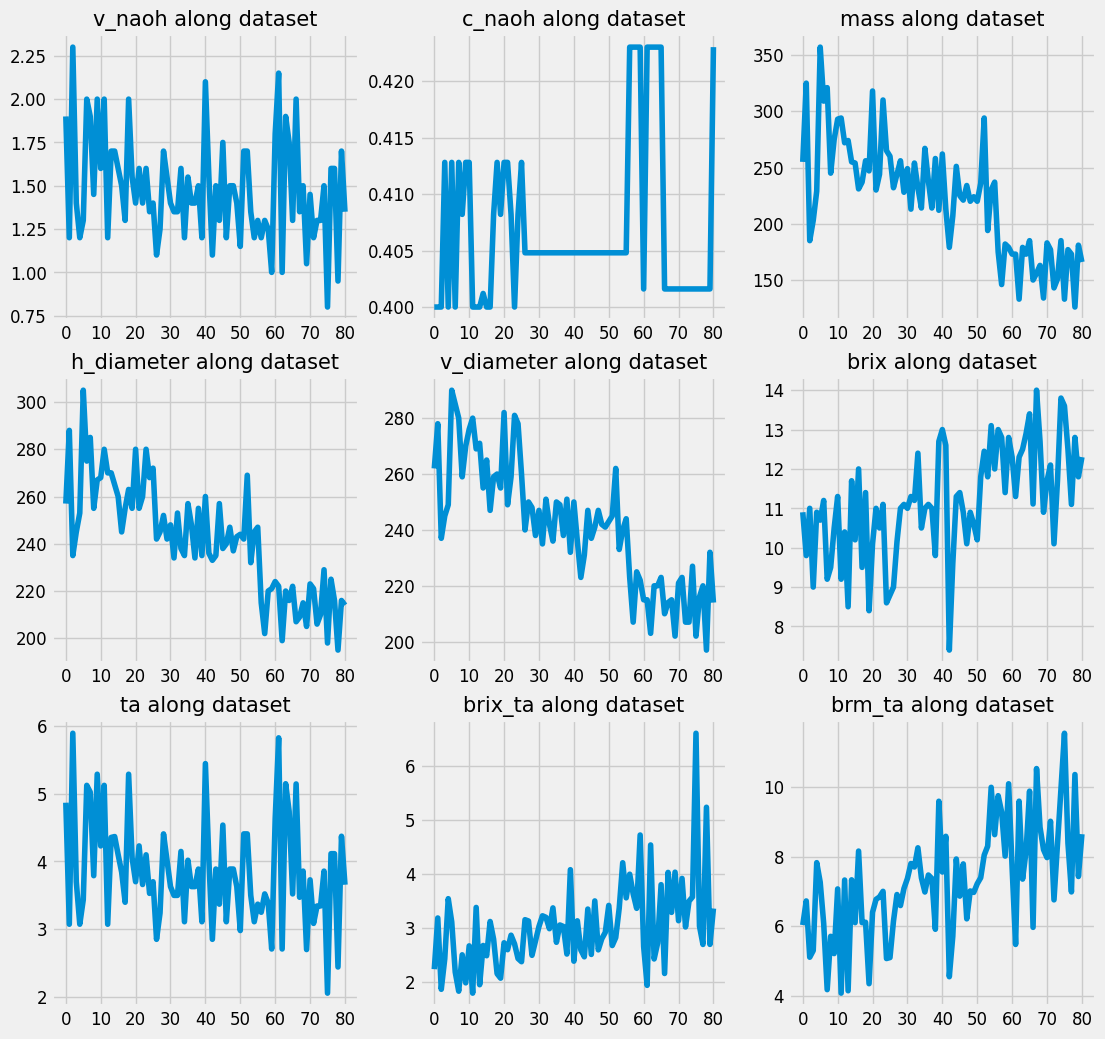

In [80]:
x = np.arange(len(dataset))
figs, axes = plt.subplots(3, 3, figsize=(12, 12))

for i in range(3):
    for j in range(3):
        ax = axes[i][j]
        index = i * 3 + j + 1
        ax.plot(x, dataset.iloc[:, index])
        ax.set_title(f"{dataset.columns[index]} along dataset", size=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.xaxis.set_ticks(np.arange(0, len(dataset), 10)) 
        ax.yaxis.set_tick_params(labelsize=12)

From the shape of lines in graph "mass", "h_diameter", "v_diameter" and "brix", we can see the lines could be divided into 3 levels along dataset. We assume that there are 3 types of data in the dataset. We could double check the name / label of dataset.

In [53]:
print(dataset["name"].to_list())

['A1', 'A2', 'A3', 'A4', 'A5', 'A7', 'A8', 'A9', 'A10', 'A11', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C8', 'C9', 'C10', 'C11', 'C12', 'C14', 'C15', 'C16', 'C17', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C28', 'C29']


We count the number of type to see whether the amount is equivalent to the shape of lines in the following graphs: "mass", "h_diameter", "v_diameter" and "brix"

In [76]:
import re

data_type = []
for name in dataset["name"].str.upper():
    data_type.append(re.findall("[A-Z]", name)[0])
    
data_type = pd.DataFrame(data_type, columns=["type"])
data_type["count"] = 1
data_type.groupby(["type"]).count()["count"]

type
A    26
B    30
C    25
Name: count, dtype: int64

We can see that the amount of type A, B, C are quite equivalent with the shape of lines.

In [91]:
dataset["type"] = data_type["type"]

pd.set_option("display.max_rows", 100)
dataset

,name,v_naoh,c_naoh,mass,h_diameter,v_diameter,brix,ta,brix_ta,brm_ta,type
0,A1,1.90,0.4000,255,257,262,10.90,4.867141,2.239508,6.032859,A
1,A2,1.20,0.4000,325,288,278,9.80,3.073984,3.188045,6.726016,A
2,A3,2.30,0.4000,185,235,237,11.00,5.891803,1.867001,5.108197,A
3,A4,1.40,0.4128,203,245,245,9.00,3.701077,2.431725,5.298923,A
4,A5,1.20,0.4000,229,253,249,10.90,3.073984,3.545887,7.826016,A
5,A7,1.30,0.4128,357,305,290,10.70,3.436714,3.113439,7.263286,A
6,A8,2.00,0.4000,309,275,285,11.20,5.123307,2.186088,6.076693,A
7,A9,1.90,0.4128,321,285,280,9.20,5.022890,1.831615,4.177110,A
8,A10,1.45,0.4082,245,255,259,9.50,3.790542,2.506238,5.709458,A
9,A11,2.00,0.4128,275,267,270,10.50,5.287252,1.985909,5.212748,A
